# 第六組 第四題 KNN 補值實作

葉高緯 製作
首先`import`需要用到的東西

In [1]:
import pandas as pd
import warnings
from sklearn import preprocessing
from sklearn.metrics.pairwise import nan_euclidean_distances
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_squared_error
from collections import Counter as ct
import random
import numpy as np
import seaborn as sns

warnings.filterwarnings('ignore')

讀取檔案

In [2]:
le = preprocessing.LabelEncoder()
data = pd.read_csv("Titanic_train.csv")


先移除我們不要的欄位，
流水號和姓名在KNN是不要的，
艙位的資料遺漏太多也去掉。

票價、票等級、性別、是否生存肯定是要的，
畢竟當時的人們提昌女人和小孩先上救生船，
有錢的人也比較有機會上救生船。

我們可以看看SibSp不同數字有沒有很大的差異，
Parch也是，
如果沒有就移除。


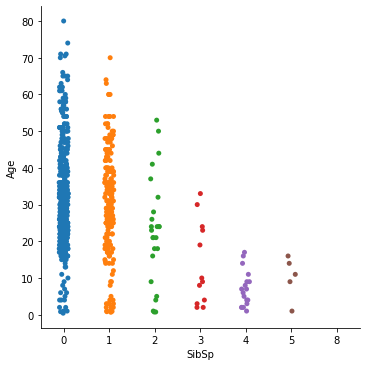

In [3]:
g = sns.catplot(x="SibSp", y="Age", data=data)

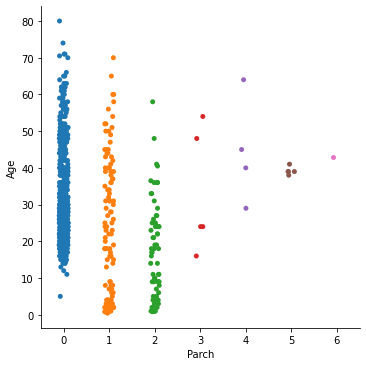

In [4]:
g = sns.catplot(x="Parch", y="Age", data=data)

看來不同數字的SibSp和不同數字的Parch有較大的差異，
可以留下來，

我們順便把性別轉換成連續型。

In [5]:
data = data.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin'])
data['Sex'] = le.fit_transform(data['Sex'])


先處理 Embarked，
先轉換資料成連續型，

因為只缺失兩筆，
而且這資料感覺也跟 Age 不太有關，
所以直接以中位數填補，
相當於 KNN 的 K = 樣本數。


In [6]:
# 以中位數填補缺失數值
data.loc[data["Embarked"] == "S", "Embarked"] = 0
data.loc[data["Embarked"] == "C", "Embarked"] = 1
data.loc[data["Embarked"] == "Q", "Embarked"] = 2
data['Embarked'] = data['Embarked'].fillna(data["Embarked"].median())


現在把準備工作都做好了，
那該怎麼找到想要的 K？
如果我想用 MSE 需要有正確的數值。

那正確的數值哪裡來？
只剩下原本那八成的 Age。

所以我想是這樣，
把已存在的數值用 MSE 找出最佳的 K，
用這個 K 帶入大概就是最好的結果，
所以我們繼續處理資料。


In [7]:
# 去除遺失的資料，重製 index

data2 = data.dropna()
data2.index = range(len(data2))
data2

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,1,22.0,1,0,7.2500,0.0
1,1,1,0,38.0,1,0,71.2833,1.0
2,1,3,0,26.0,0,0,7.9250,0.0
3,1,1,0,35.0,1,0,53.1000,0.0
4,0,3,1,35.0,0,0,8.0500,0.0
...,...,...,...,...,...,...,...,...
709,0,3,0,39.0,0,5,29.1250,2.0
710,0,2,1,27.0,0,0,13.0000,0.0
711,1,1,0,19.0,0,0,30.0000,0.0
712,1,1,1,26.0,0,0,30.0000,1.0


接下來我們開始準備動手處理 MSE，
隨機遺失的資料數量選擇為140，
因為大概等於總體的兩成。

In [8]:
def myMSE(k):
    a = random.sample(list(data2.index), 140)
    missing_data = data2.copy()
    missing_data['Age'].iloc[a] = np.nan

    imputer = KNNImputer(n_neighbors=k, weights='distance', add_indicator=True)
    pred_data = pd.DataFrame(imputer.fit_transform(missing_data))

    y_true1 = data2['Age']
    y_pred1 = pred_data[3]
    MSE_h = mean_squared_error(y_true1, y_pred1)
    return MSE_h


接下來打算把所有考慮的k都跑一次，
看看哪一個k能跑出最小的MSE。

k值的考慮範圍很重要，
範圍大的k就不精準，
而且跑出來的最小k差距很大，
我曾經嘗試跑出0~300中最小MSE的K，
結果是50~250都有可能，
而且填補的數據類近似於Pclass的平均值。
我們要找到一個範圍剛好讓差距很明顯。

我想1~5非常合適，
有明顯的差距，
我猜想在鐵達尼號旅遊的大概都是家族旅行，
一個家庭的組成年紀應該差不多，
所以那個家族的老人也會跟其他家族的老人差不多，
小孩也是，
家庭的人數也在5個人左右。

In [9]:
def find_min_MSE():
    res = []
    for k in range(1,8):
        res.append(myMSE(k))
    res_min = np.min(res)
    
    for i in range(len(res)):
        if res_min == res[i]:
            return i+1

重複一千次這個隨機行為，
統計看看哪個k的MSE最小。

In [10]:
def find_best_K():    
    rec = []
    for i in range(1000):
        rec.append(find_min_MSE())
    count = ct(rec)
    return dict(count)

find_best_K()

{4: 146, 5: 201, 6: 241, 7: 303, 3: 81, 2: 28}

最後回到本題，
k = 7的話應該是最好的，
MSE 最小的次數最多。

In [11]:

def myKNN(tran_data, k):
    imputer = KNNImputer(n_neighbors=k, weights='distance', add_indicator=True)
    pred_data = pd.DataFrame(imputer.fit_transform(tran_data))
    return pred_data

data_k_7 = myKNN(data.copy(), 7)

data_k_7[data_k_7[8] == 1]

,0,1,2,3,4,5,6,7,8
5,0.0,3.0,1.0,40.805611,0.0,0.0,8.4583,2.0,1.0
17,1.0,2.0,1.0,35.666667,0.0,0.0,13.0000,0.0,1.0
19,1.0,3.0,0.0,15.000000,0.0,0.0,7.2250,1.0,1.0
26,0.0,3.0,1.0,35.125000,0.0,0.0,7.2250,1.0,1.0
28,1.0,3.0,0.0,19.000000,0.0,0.0,7.8792,2.0,1.0
...,...,...,...,...,...,...,...,...,...
859,0.0,3.0,1.0,26.000000,0.0,0.0,7.2292,1.0,1.0
863,0.0,3.0,0.0,33.884983,8.0,2.0,69.5500,0.0,1.0
868,0.0,3.0,1.0,24.833333,0.0,0.0,9.5000,0.0,1.0
878,0.0,3.0,1.0,26.714286,0.0,0.0,7.8958,0.0,1.0


接下來我們把補好值的檔案儲存起來，
把 8 那一欄給去掉，
同時也要把年齡的小數去掉。

In [12]:
data_k_7 = data_k_7.drop(columns=8)
data_k_7[3] = list(map(lambda x: int(x),data_k_7[3]))
header = data.columns.tolist()
pd.DataFrame(data_k_7).to_csv('Titanic_train_KNN.csv', header=header, index=0)

這樣我們就得到補好值的檔案了。